# OsuLearn
##### Machine Learning para jogar mapas de osu!

^^^

Isso aí, tô sem mais nada pra fazer, bora criar uma IA que joga osu! )o)

## Importar umas coisas...

In [1]:
# Machine Learning
import tensorflow as tf
import keras

import numpy as np
import pandas as pd

# Plotagem
import matplotlib.pyplot as plt

# Utilidades
import os
import math

# Lógica do osu!
import osu.beatmap
import osu.replay

import osulearn

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


## Constantes

Aqui tem uns caminhos para os arquivos que precisamos:

In [2]:
# Pasta do osu!
OSU_FOLDER = "C:\\" + os.path.join("Program Files (x86)", "Jogos", "osu!")

## Dados para treinamento...

In [3]:
import osu.replay
import re

from glob import glob, escape

def load_replay_files():
    replay_training_set = []
    pattern = os.path.join(OSU_FOLDER, "Replays", "* Osu*.osr")
    _cache = {}
    for replay_file in glob(pattern):
        try:
            info = re.search(r"([^\\/]+) \- (.+ \- .+) \[(.+)\] \((.+)\)", replay_file)
            player, bmap, diff, date = info[1], info[2], info[3], info[4]
            print(player, bmap, diff, date)

            fpat = os.path.join(OSU_FOLDER, "Songs", "**", "*" + escape(bmap) + "*" + escape("[" + diff + "]") + ".osu")

            if fpat in _cache:
                beatmap_file = _cache[fpat]
            else:
                beatmap_file = glob(fpat)

            if len(beatmap_file) > 0:
                _cache[fpat] = beatmap_file
                beatmap = osu.beatmap.load(beatmap_file[0])
                if re.search("v14", beatmap.format_version) != None:
                    replay = osu.replay.load(replay_file)

                    if not (replay.mods & 0x10 or replay.mods & 0x40):
                        replay_training_set.append([beatmap, replay])
                        print("OK", len(replay_training_set) - 1)
                    else:
                        print("Replay uses DT or HR. Those mods are not supported yet.")
                else:
                    print("Wrong format version")
            else:
                print("Beatmap file not found")
        except Exception as e:
            print("Failed:", e)
        print()
            
        
    return replay_training_set

In [4]:
from importlib import reload
reload(osulearn)
reload(osu.replay)
reload(osu.beatmap)

try:
    X = np.load('input_data.npy')
except:
    try:
        replay_training_set
    except NameError:
        replay_training_set = load_replay_files()
    
    print("Processing Input Data...")
    X = osulearn.create_training_data(replay_training_set)
    print()
    np.save('input_data.npy', X)
    
try:
    y = np.load('target_data.npy')
except:
    try:
        replay_training_set
    except NameError:
        replay_training_set = load_replay_files()   
    
    print("Processing Target Data...")
    y = osulearn.create_target_data(replay_training_set)
    
    np.save('target_data.npy', y)

print(X.shape, y.shape)

BzMasked (K)NoW_NAME - Freesia Expert 2018-12-30
OK 0

BzMasked (K)NoW_NAME - Freesia Expert 2018-12-31
OK 1

BzMasked 3R2 - Bunny Panic!!! Bunny Extinction 2018-12-30
OK 2

BzMasked 55x55 - MRAZ' (feat. Larin) Insane 2018-12-30
OK 3

BzMasked Aimer with chelly (EGOIST) - ninelie (REDSHiFT x Vesuvia remix) Daydream 2018-06-01
OK 4

BzMasked Aiobahn & Yunomi - Makuramoto ni Ghost NiNo's Together 2018-03-31
Failed: Not a osu!std replay

BzMasked Aitsuki Nakuru - Monochrome Butterfly Extra 2017-09-09
OK 5

BzMasked Aitsuki Nakuru - Monochrome Butterfly Mysterious 2017-08-04
OK 6

BzMasked Aitsuki Nakuru - Presenter Noel 2019-01-01
OK 7

BzMasked Alex Gaudino feat. Crystal Waters - Destination Calabria Destination Unknown 2017-11-25
OK 8

BzMasked Alex Gaudino feat. Crystal Waters - Destination Calabria Destination Unknown 2017-12-01
OK 9

BzMasked Amidst - Phantasy NYA! 2018-12-30
OK 10

BzMasked Analogfish - Speed schoolboy's Extra 2019-01-01
OK 11

BzMasked Asterisk - Ren-chon no Drum '

OK 98

BzMasked Roselia - Six Trillion Years and Overnight Story Existence 2018-12-30
OK 99

BzMasked Sakuzyo - Imprinting Arles AR9.5 2018-03-12
OK 100

BzMasked Sakuzyo - Imprinting Arles AR9.5 2018-12-17
OK 101

BzMasked Sakuzyo - Imprinting Arles AR9.5 2018-12-17
OK 102

BzMasked Sakuzyo - Imprinting Arles AR9.5 2018-12-31
OK 103

BzMasked - saradisk 210 - Maikaze Destroyer 2018-12-30
OK 104

BzMasked - saradisk 220 - Kumano oko's Extra 2018-12-30
OK 105

BzMasked Sayuri x MY FIRST STORY - Reimei (TV Size) xChippy's Extra 2018-12-30
OK 106

BzMasked Sebastien Pintiaux & Caroline Szatapski - Sur tes pas Dans la Legende! 2018-12-30
OK 107

BzMasked Seiryu - AO-Infinity Refraction 2018-12-17
OK 108

BzMasked Seiryu - AO-Infinity Refraction 2019-01-01
OK 109

BzMasked Seiryu - BLUE DRAGON Kyshiro's Extra 2017-12-02
OK 110

BzMasked Sex Whales & Fraxo - Dead To Me (feat. Lox Chatterbox) extrad1881 (ar 10) 2017-09-24
OK 111

BzMasked Sleeping With Sirens - If You Can't Hang Bearizm's Ext

## Modelo de rede neural

Agora começa a festa...

In [18]:
import importlib

importlib.reload(keras)
importlib.reload(tf)

from keras.models import Model, Sequential
from keras.layers import    Dense, Dropout, Activation,\
                            CuDNNLSTM, CuDNNGRU, concatenate,\
                            Input, Reshape, Conv1D, UpSampling1D,\
                            GaussianNoise

REPLAY_FEATURES = ['x', 'y']
MAP_FEATURES = ['x', 'y', 'time_left', 'is_slider', 'is_spinner']

map_input = Input(shape=(X.shape[1], X.shape[2]), name='map_info')

out = CuDNNLSTM(16, return_sequences=True)(map_input)
out = Dense(64, activation='linear')(out)
out = Dense(64, activation='linear')(out)
out = Dense(len(REPLAY_FEATURES), activation='linear')(out)
#out = GaussianNoise(0.1)(out)

model = Model(inputs=map_input, outputs=out)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
map_info (InputLayer)        (None, 1024, 5)           0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 1024, 16)          1472      
_________________________________________________________________
dense_4 (Dense)              (None, 1024, 64)          1088      
_________________________________________________________________
dense_5 (Dense)              (None, 1024, 64)          4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1024, 2)           130       
Total params: 6,850
Trainable params: 6,850
Non-trainable params: 0
_________________________________________________________________


In [7]:
def plot_info(compare):
    %matplotlib inline
    
    plt.ylim((-1, 1))
    for data in compare:
        plt.plot([(x) for x, y in data])
    for data in compare:
        plt.plot([(y) for x, y in data])
    plt.show()
    
#     for data in compare:
#         plt.plot([(a) for distance, angle in data])
#     plt.show()
    
#     for data in compare:
#         plt.plot([(b) for distance, angle in data])

In [22]:
from random import randint
from sklearn.model_selection import train_test_split

ITERATIONS = 8
EPOCHS = 16

acc = []
loss = []

try:
    acc
    loss
except NameError:
    acc = []
    loss = []
    
#model.load_weights("model.hdf5")
for i in range(ITERATIONS):
    print("-" * 80)
    print("Iteration #%d" % (i + 1))
    print("-" * 80)
    print()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randint(0, 100))
    h = model.fit(X_train, y_train, batch_size=len(X_train), epochs=EPOCHS, verbose=1)
    acc += h.history['acc']
    loss += h.history['loss']
    print()

model.save_weights("model.hdf5")

--------------------------------------------------------------------------------
Iteration #1
--------------------------------------------------------------------------------

Epoch 1/16
729/729 [==============================] - 0s 322us/step - loss: 0.0079 - acc: 0.7955
Epoch 2/16
729/729 [==============================] - 0s 322us/step - loss: 0.0079 - acc: 0.7968
Epoch 3/16
729/729 [==============================] - 0s 318us/step - loss: 0.0079 - acc: 0.7974
Epoch 4/16
729/729 [==============================] - 0s 303us/step - loss: 0.0079 - acc: 0.7967
Epoch 5/16
729/729 [==============================] - 0s 304us/step - loss: 0.0079 - acc: 0.7946
Epoch 6/16
729/729 [==============================] - 0s 307us/step - loss: 0.0079 - acc: 0.6502
Epoch 7/16
729/729 [==============================] - 0s 317us/step - loss: 0.0079 - acc: 0.6496
Epoch 8/16
729/729 [==============================] - 0s 306us/step - loss: 0.0079 - acc: 0.6497
Epoch 9/16
729/729 [============================

729/729 [==============================] - 0s 308us/step - loss: 0.0072 - acc: 0.6536
Epoch 13/16
729/729 [==============================] - 0s 315us/step - loss: 0.0072 - acc: 0.6543
Epoch 14/16
729/729 [==============================] - 0s 310us/step - loss: 0.0072 - acc: 0.8034
Epoch 15/16
729/729 [==============================] - 0s 307us/step - loss: 0.0072 - acc: 0.8056
Epoch 16/16
729/729 [==============================] - 0s 303us/step - loss: 0.0072 - acc: 0.8069

--------------------------------------------------------------------------------
Iteration #6
--------------------------------------------------------------------------------

Epoch 1/16
729/729 [==============================] - 0s 295us/step - loss: 0.0076 - acc: 0.7993
Epoch 2/16
729/729 [==============================] - 0s 307us/step - loss: 0.0076 - acc: 0.7994
Epoch 3/16
729/729 [==============================] - 0s 306us/step - loss: 0.0076 - acc: 0.7995
Epoch 4/16
729/729 [==============================] - 

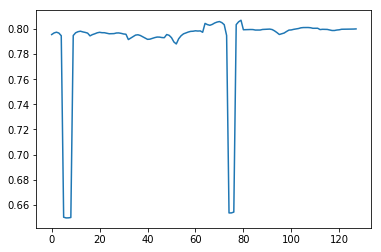

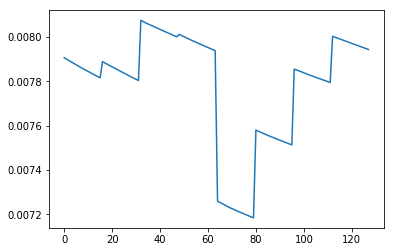

In [23]:
%matplotlib inline

plt.plot(acc)
plt.show()

plt.plot(loss)
plt.show()

0


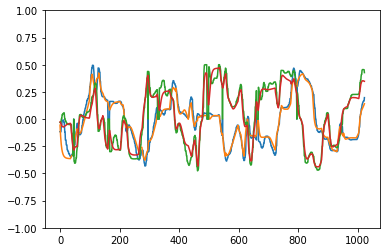

1


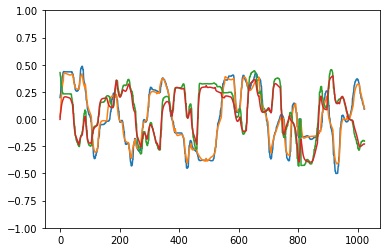

2


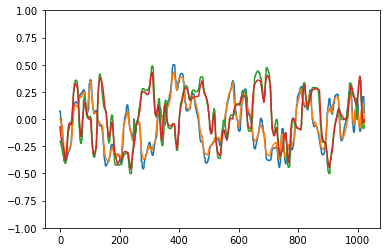

3


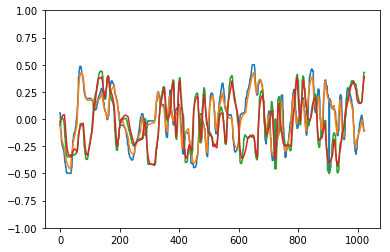

4


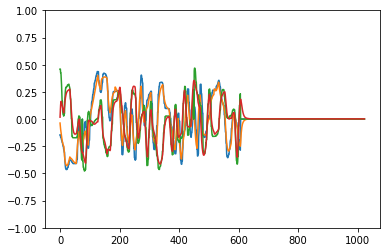

5


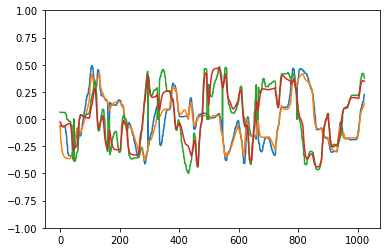

6


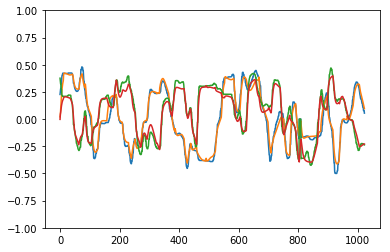

7


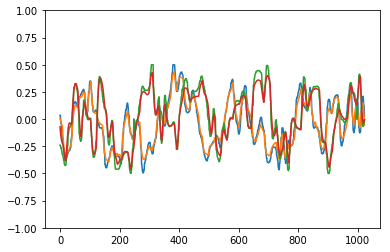

8


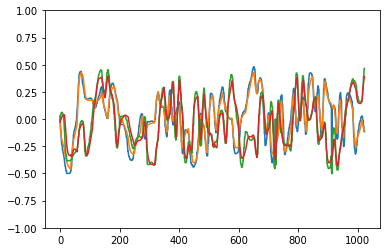

9


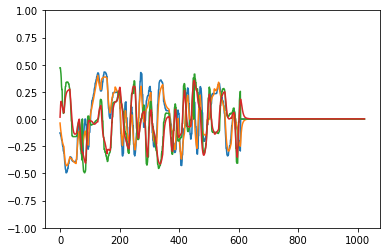

10


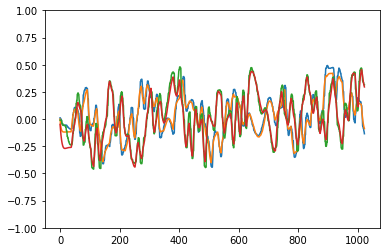

11


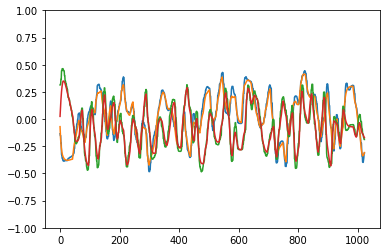

12


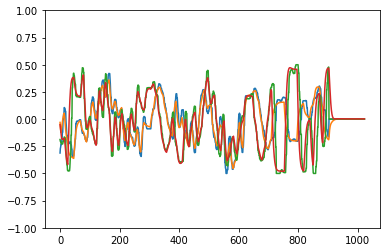

13


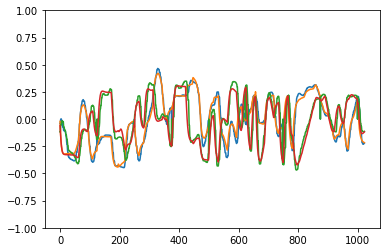

14


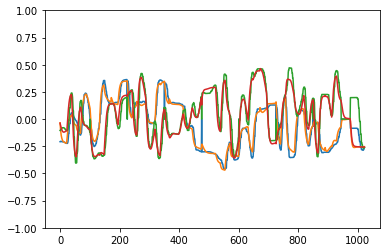

15


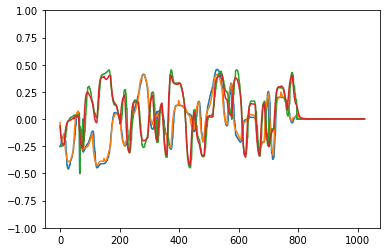

16


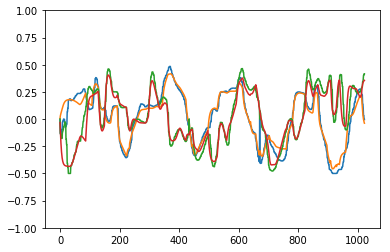

17


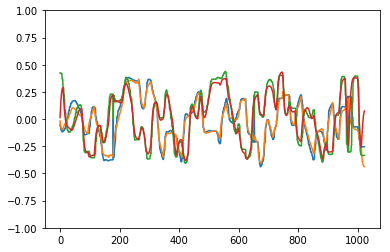

18


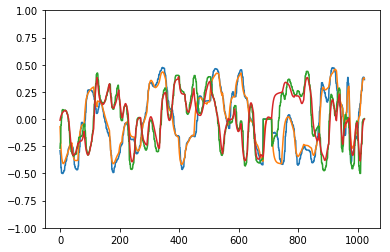

19


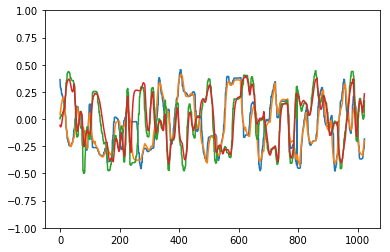

20


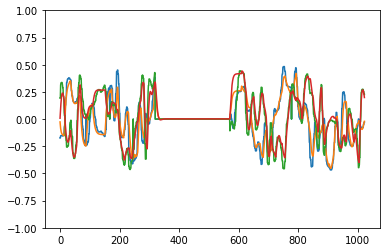

21


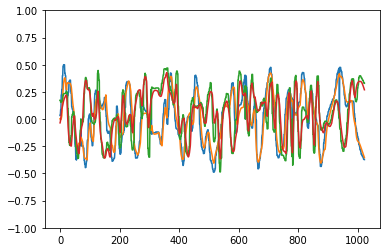

22


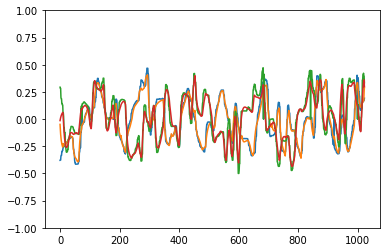

23


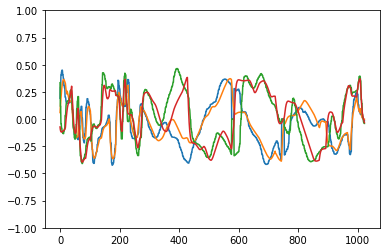

24


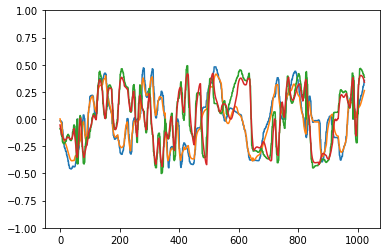

25


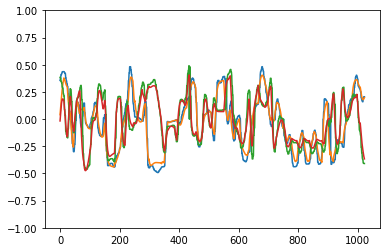

26


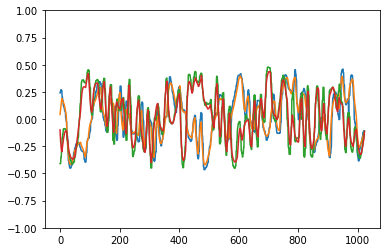

27


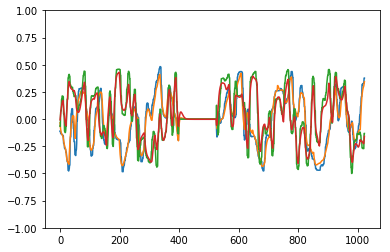

28


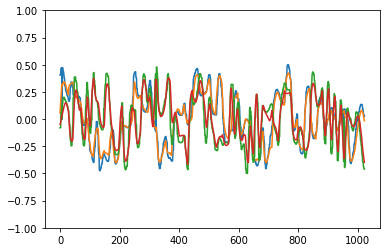

29


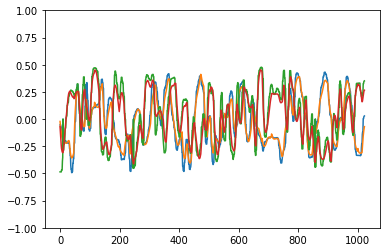

30


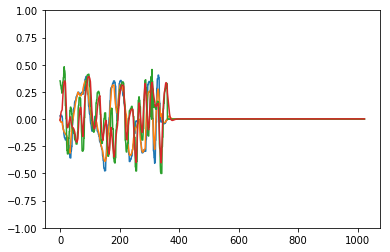

31


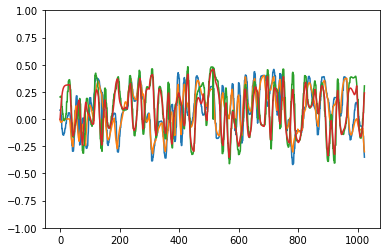

32


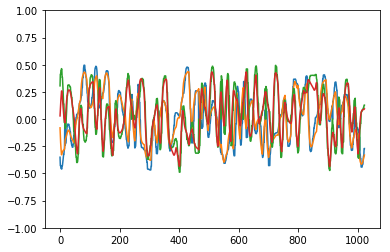

33


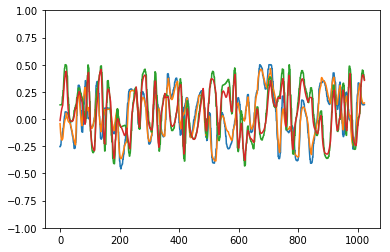

34


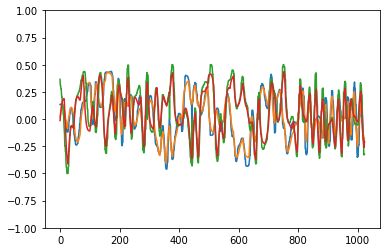

35


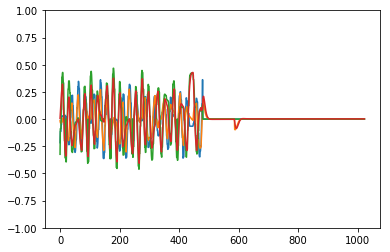

36


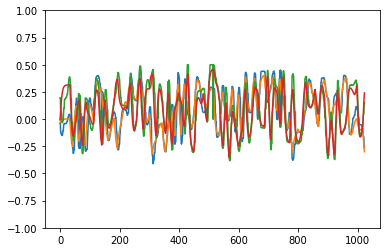

37


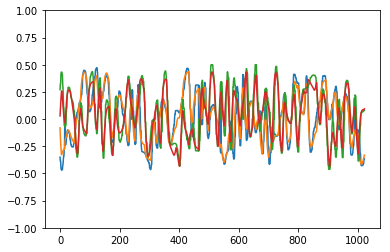

38


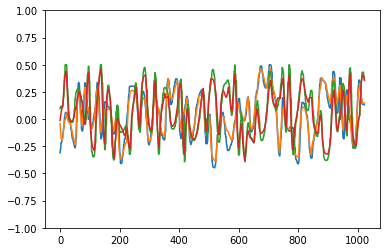

39


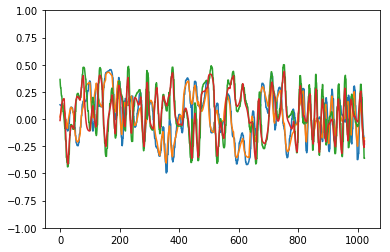

40


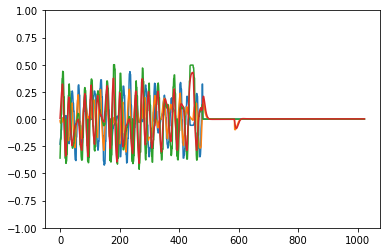

41


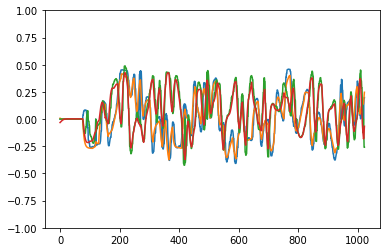

42


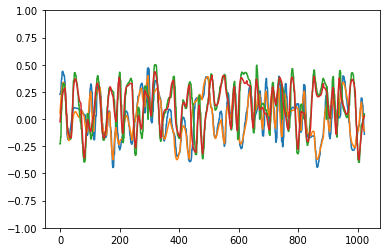

43


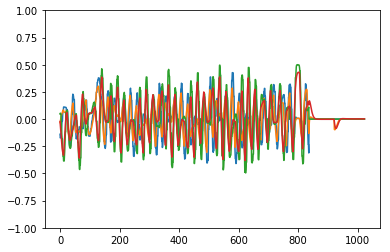

44


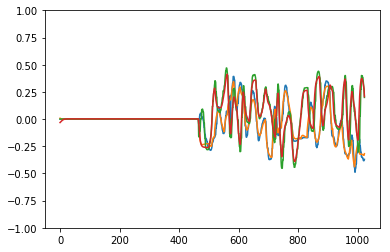

45


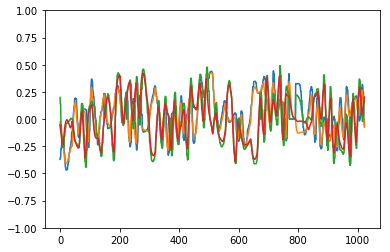

46


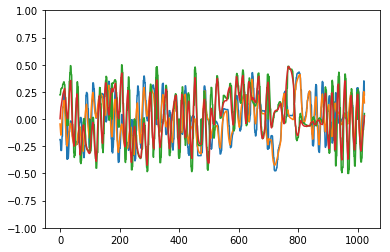

47


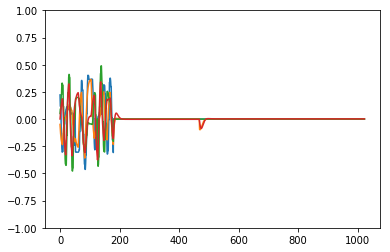

48


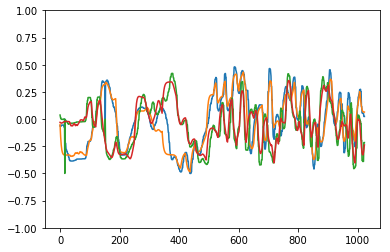

49


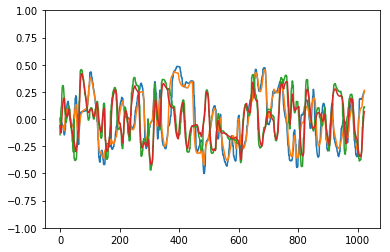

In [24]:
predicted = model.predict(X)

for i in range(50):#len(predicted)):
    print(i)
    plot_info([y[i], predicted[i]])

Uta


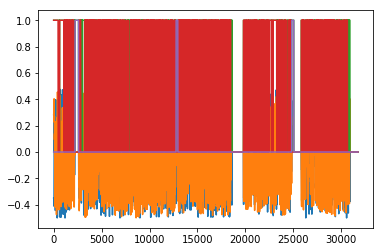

Done.


In [25]:
#importlib.reload(osulearn)

BEATMAPS_FOLDER = 'C:\\Program Files (x86)\\Jogos\\osu!\\Songs\\'
#BEATMAP = glob(BEATMAPS_FOLDER + "\\**\\*Kami no Kotoba*byfar*Voice of God*.osu")[0]
#BEATMAP = glob(BEATMAPS_FOLDER + "\\**\\*My Love*Insane*.osu")[0]
BEATMAP = glob(BEATMAPS_FOLDER + "\\**\\*Uta*Himei*.osu")[0]

beatmap = osu.beatmap.load(BEATMAP)

xx = osulearn.create_training_data([(beatmap, None)])

plt.plot(np.concatenate(xx))
plt.show()

predicted = model.predict(xx)

np.save('osu/replay.npy', np.concatenate(predicted))
print("Done.")